In [80]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

sys.path.append("../modules")
from load_switrs import get_switrs_df, set_factorize
from highways import get_roads, get_road_codes, get_last_exit

roads = get_roads()
road_codes = get_road_codes()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
if True:
    df = pd.DataFrame.from_csv('../data/switrs.csv')
else:
    df = get_switrs_df()
    print df.size
    
    cols = ['State_Route', 'Caltrans_County', 'Postmile_Code']
    df['Last_Exit'] = df[cols].apply(get_last_exit, axis=1)
    df.Last_Exit = df.Last_Exit.str.replace(u'\u2014','-')
    
    df.to_csv('../data/switrs.csv')
    
df.sample(15)

,Case_ID,Jurisdiction,Officer_ID,Reporting_District,CHP_Shift,Population,County_City_Location,Special_Condition,Beat_Type,CHP_Beat_Type,...,Collision_Year,Collision_Month,Collision_Day,Collision_DayOfWeek,Collision_Hour,Collision_Minute,Collision_Hours,Collision_Minutes,Postmile_Code,Last_Exit
157283,6110342,9670,15587,NaN,2,5.0,3003,0,1,3,...,2013,6,21,4,14,0,14.000000,840.0,R1.25,21
211539,6587357,9530,20718,NaN,2,9.0,1900,0,1,3,...,2014,7,17,3,16,0,16.000000,960.0,R10.29,10A
224646,6977145,9550,20755,NaN,2,5.0,1919,0,1,3,...,2014,9,13,5,17,0,17.000000,1020.0,R17.48,17A
14678,4007285,9465,016957,NaN,2,6.0,5002,0,1,3,...,2008,12,17,2,16,58,16.966667,1018.0,R20.478,230
29188,4290218,9530,019101,NaN,2,7.0,1942,0,1,1,...,2009,5,3,6,19,0,19.000000,1140.0,R6.97,07A
63201,4815284,9835,17111,NaN,3,9.0,3600,0,1,1,...,2010,7,18,6,1,55,1.916667,115.0,R9.1,NaN
201978,6485239,9565,020439,NaN,2,7.0,1942,0,1,1,...,2014,4,12,5,18,50,18.833333,1130.0,R6.23,NaN
116195,5451437,9435,18860,NaN,2,9.0,1000,0,1,3,...,2011,12,19,0,15,18,15.300000,918.0,R3.08,124
120182,5578284,9860,11960,NaN,2,6.0,3610,0,1,1,...,2012,4,2,0,14,26,14.433333,866.0,R23.62,NaN
192742,6365817,9420,018626,NaN,2,9.0,1500,0,1,3,...,2014,2,12,2,15,50,15.833333,950.0,R28.37,28


In [30]:
def get_highway_segment_df(row):
    return df[(df.State_Route     == row[0]) \
            & (df.Last_Exit       == row[1]) \
            & (df.Caltrans_County == row[2])]

def get_total_accidents(row):
    df = get_highway_segment_df(row)
    
    return len(df)

def get_avg_latitude(row):
    df = get_highway_segment_df(row)
        
    return df.Latitude.mean()

def get_avg_longitude(row):
    df = get_highway_segment_df(row)
        
    return df.Longitude.mean()

In [32]:
# Setup the highway segment data (split by highway)
df_highways = {}

for r in sorted(road_codes):
    # Start by loading Exit / County pairs
    df_r = df[(df.State_Route == r)][['Last_Exit', 'Caltrans_County']]
    
    if len(df_r.values) == 0:
        continue

    exit_list = []
    # Useful function that filters to only unique pairs
    for e in np.vstack({tuple(row) for row in df_r.values}):
        if e[0] != '0':
            exit_list.append([r, e[0], e[1]])
            
    # If no pairs are found, something is horribly, horribly wrong!
    if len(exit_list) == 0:
        print 'Error Loading %6s!' % road_codes[r]
        continue
            
    # Otherwise, make the results into a DataFrame for each highway
    df_m = pd.DataFrame.from_records(
        exit_list,
        columns = ['Highway', 'Exit', 'County']
    )    
    
    # Then start calculating features for each one
    print 'Loading %6s...' % road_codes[r]
        
    df_m['Total_Accidents'] = df_m.apply(get_total_accidents, axis = 1)
    df_m['Avg_Latitude'] = df_m.apply(get_avg_latitude, axis = 1)
    df_m['Avg_Longitude'] = df_m.apply(get_avg_longitude, axis = 1)

    # And save the result for combining into the full set
    df_highways[r] = df_m.set_index('Exit')

Loading   CA-1...
Loading   CA-4...
Loading    I-5...
Loading    I-8...
Loading   I-10...
Loading  CA-14...
Loading   I-15...
Loading  CA-22...
Loading  CA-24...
Loading   I-40...
Loading  CA-41...
Loading  US-50...
Loading  CA-55...
Loading  CA-57...
Loading  CA-58...
Loading  CA-60...
Loading   I-80...
Loading  CA-85...
Loading  CA-91...
Loading  CA-92...
Loading  CA-99...
Loading US-101...
Loading  I-105...
Loading CA-110...
Loading CA-118...
Loading CA-120...
Loading CA-126...
Loading CA-134...
Loading CA-170...
Loading CA-198...
Loading  I-205...
Loading  I-210...
Loading CA-215...
Loading  I-280...
Loading  I-380...
Loading  I-580...
Loading  I-605...
Loading  I-680...


In [ ]:
df_main_cols = [
    'Segment_ID', 'Highway', 'Last_Exit', 'Total_Accidents', 
    'County', 'County_Population', 
    'Morning_Commute_Accidents', 'Daytime_Accidents', 
    'Evening_Commute_Accidents', 'Nighttime_Accidents',
    'Interstate', 'Avg_Latitude', 'Avg_Longitude'
]

In [75]:
if True:
    # Merge everything into one DataFrame for training / predicting
    df_total = pd.DataFrame()

    for r in sorted(road_codes.keys()):
        if r in df_highways:
            df_total = df_total.append(df_highways[r])
            
    county_list = set_factorize(df_total, 'County')    
#     cl = dict(zip(county_list.values, range(len(county_list))))
        
    df_total = df_total.dropna()
    df_total.to_csv('../data/highway_segments.csv')
    
else:
    df_total = pd.DataFrame.from_csv('../data/highway_segments.csv')
    
    df_highways = {}    
    for r in sorted(road_codes.keys()[1:]):
        df_highways[r] = df_total[df_total.Highway == r]

print df_total.size
df_total.head(30)

4200


,Highway,County,Total_Accidents,Avg_Latitude,Avg_Longitude,County_old
Exit,,,,,,
66B,4,0,118,37.964213,-121.273740,6
17,4,1,40,38.018575,-121.959024,7
67,4,0,150,37.952952,-121.273685,6
30,4,1,22,37.971750,-121.723967,7
15A,4,1,11,38.008486,-122.025333,7
10,4,1,9,37.994212,-122.108251,7
19,4,1,40,38.019835,-121.961808,7
68A,4,0,182,37.959929,-121.251977,6
15B,4,1,20,38.012377,-122.007100,7


In [76]:
use_cols = ['Highway', 'County', 'Avg_Latitude', 'Avg_Longitude']

X = df_total[use_cols]
y = df_total.Total_Accidents

rf = RandomForestRegressor(
    n_estimators = 10000,
    verbose = 1,
)
rf.fit(X, y)
       
print "Features sorted by score:"
for s in sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), use_cols), reverse=True):
    print '\t%.4f - %s' % (s[0], s[1])

[Parallel(n_jobs=1)]: Done 10000 out of 10000 | elapsed:   12.8s finished


Features sorted by score:
	0.5466 - Avg_Latitude
	0.3526 - Avg_Longitude
	0.0720 - Highway
	0.0288 - County


[Parallel(n_jobs=1)]: Done 10000 out of 10000 | elapsed:    5.4s finished


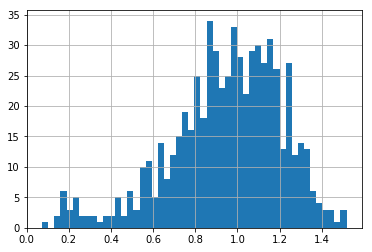

In [88]:
df_predict = df_total#df_highways[85].copy()

df_predict['Predicted_Accidents'] = rf.predict(df_total[use_cols])
df_predict['Ratio'] = df_predict.Total_Accidents / df_predict.Predicted_Accidents

# print df_predict[['Total_Accidents', 'Predicted_Accidents']].head(40).sort_index()

df_predict.Ratio[df_predict.Total_Accidents > 10].hist(bins=50);

df_predict.to_csv('../data/df_predict_v0.0.csv')

In [85]:
df_predict.sample(20)

,Highway,County,Total_Accidents,Avg_Latitude,Avg_Longitude,County_old,Predicted_Accidents,Ratio
Exit,,,,,,,,
789,5,3,3,41.789033,-122.569140,9,8.2333,0.364374
22,85,17,31,37.374816,-122.099686,23,27.2316,1.138383
01B,280,17,388,37.326000,-121.851947,23,383.2813,1.012311
07,170,2,276,34.177731,-118.394332,8,294.7160,0.936495
743,5,3,40,41.413186,-122.380711,9,31.8638,1.255343
748,5,3,14,41.409189,-122.401208,9,12.8191,1.092120
35,60,15,78,34.032753,-117.641758,21,158.8040,0.491172
38,60,15,62,34.027662,-117.583542,21,72.2191,0.858499
37,60,15,64,34.048533,-117.599118,21,73.7117,0.868248
